In [2]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy
from deepdiff import DeepDiff

from sklearn.model_selection import train_test_split

from srcmodules.Scenes import Scene

In [3]:
%config InlineBackend.figure_format = 'retina'
floatX = aesara.config.floatX
rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

In [36]:
def my_callback(meanfield, elbo, n):
    if n%2000 == 0:# and n>200:
        acc = print_acc_from_trace(meanfield, n)
        accs.append(acc)
        ns.append(n)

# Ex. 1: Direct mapping actions to gestures
Choose from datasets:
- `dataset01`: acc ~99% (on test_data)
- `dataset02`: acc ~76% (on test_data)
- `dataset03`: acc ~99% (on test_data)
- `dataset03_10000d` (10000 samples): acc ~99% (on test_data)

In [4]:
dataset_name = 'dataset02' 

In [5]:
# dataset 
data = np.load(f"{os.path.expanduser('~')}/Documents/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [3]:
def remove_input_duplicates(dataset):
    removals = []
    for n,sample1 in enumerate(dataset):
        for m,sample2 in enumerate(dataset):
            if n == m: continue # do not compare to itself
            if DeepDiff(sample1[0], sample2[0], ignore_order=True) == {}: # compare the scene dict
                print(n)
                dataset.pop(n)
                break
    return dataset

In [57]:
dataset = remove_input_duplicates(dataset)

0
1
4


In [6]:
def get_X_Y(dataset):
    X = np.zeros([len(dataset),len(dataset[0][2])])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,i in enumerate(dataset):
        Y[n] = A.index(i[1][0])
        X[n] = i[2]
    return X, Y
X,Y = get_X_Y(dataset)

In [7]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

> When the observation vector includes ints, it is very easy to exclude the samples from `X_test` data, which are in `X_train`, but when the variables are floats, what is the suitable threshold to know the observations is the same?

- 1 Layer NN
- Seaches for weights representing the policy (Gestures ->  Actions)
- Forward is simple: `sigmoid(ann_input * weights_in_1)`

In [8]:
def construct_nn(ann_input, ann_output):
    n_hidden = lenA
    
    # Initialize the weights/policy values
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("gestures", X_train)
        ann_output = pm.Data("intent", Y_train)

        # Weights/policy symbolic variable
        weights_in_1 = pm.Normal(
            "policy", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )
        act_out = pm.math.sigmoid(pm.math.dot(ann_input, weights_in_1))
        out = pm.Categorical(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],
        )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

In [9]:
graphvizfig = pm.model_to_graphviz(neural_network)
graphvizfig.render(filename=f"/home/petr/Pictures/model_graph_{str(np.random.random())[2:]}")

'/home/petr/Pictures/model_graph_9072871919911837.pdf'

#### Sampled posterior predictive to predicted ids
- Makes histogram of ids
- chooses the max id (action) 

In [40]:
def ppc_to_pred(ppc):
    pred = []
    for i in range(ppc['out'].shape[1]): # for X_test samples
        one_sample = []
        for j in range(ppc['out'].shape[0]):
            one_sample.append(ppc['out'][j][i])
        sums = np.zeros(lenA)
        for s in one_sample:
            sums[s] += 1

        pred.append(np.argmax(sums))
    return np.array(pred)

Used in callback. Computes, prints and saves the accuracy at this point of learning

In [18]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"gestures": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [17]:
ns = []
accs = []
#method = pm.ADVI()
neural_network = construct_nn(X_train, Y_train)
with neural_network:
    approx = pm.fit(n=25_000, callbacks=[my_callback])#, method=method)

n: 2000, Accuracy = 23.0%
n: 4000, Accuracy = 35.0%
n: 6000, Accuracy = 49.2%
n: 8000, Accuracy = 58.4%
n: 10000, Accuracy = 69.4%
n: 12000, Accuracy = 67.2%
n: 14000, Accuracy = 72.0%
n: 16000, Accuracy = 71.2%
n: 18000, Accuracy = 71.2%
n: 20000, Accuracy = 73.6%
n: 22000, Accuracy = 73.4%
n: 24000, Accuracy = 75.2%


Finished [100%]: Average Loss = 553.91


In [20]:
trace = approx.sample(draws=500)
with neural_network:
    pm.set_data(new_data={"gestures": X_test})
    ppc = pm.sample_posterior_predictive(trace)
pred = ppc_to_pred(ppc)
f"Accuracy = {(pred == Y_test).mean() * 100}%"

In [21]:
pred = ppc_to_pred(ppc)

In [22]:
np.histogram(pred,6)[0]

array([136,   0,  12,   0, 175, 177])

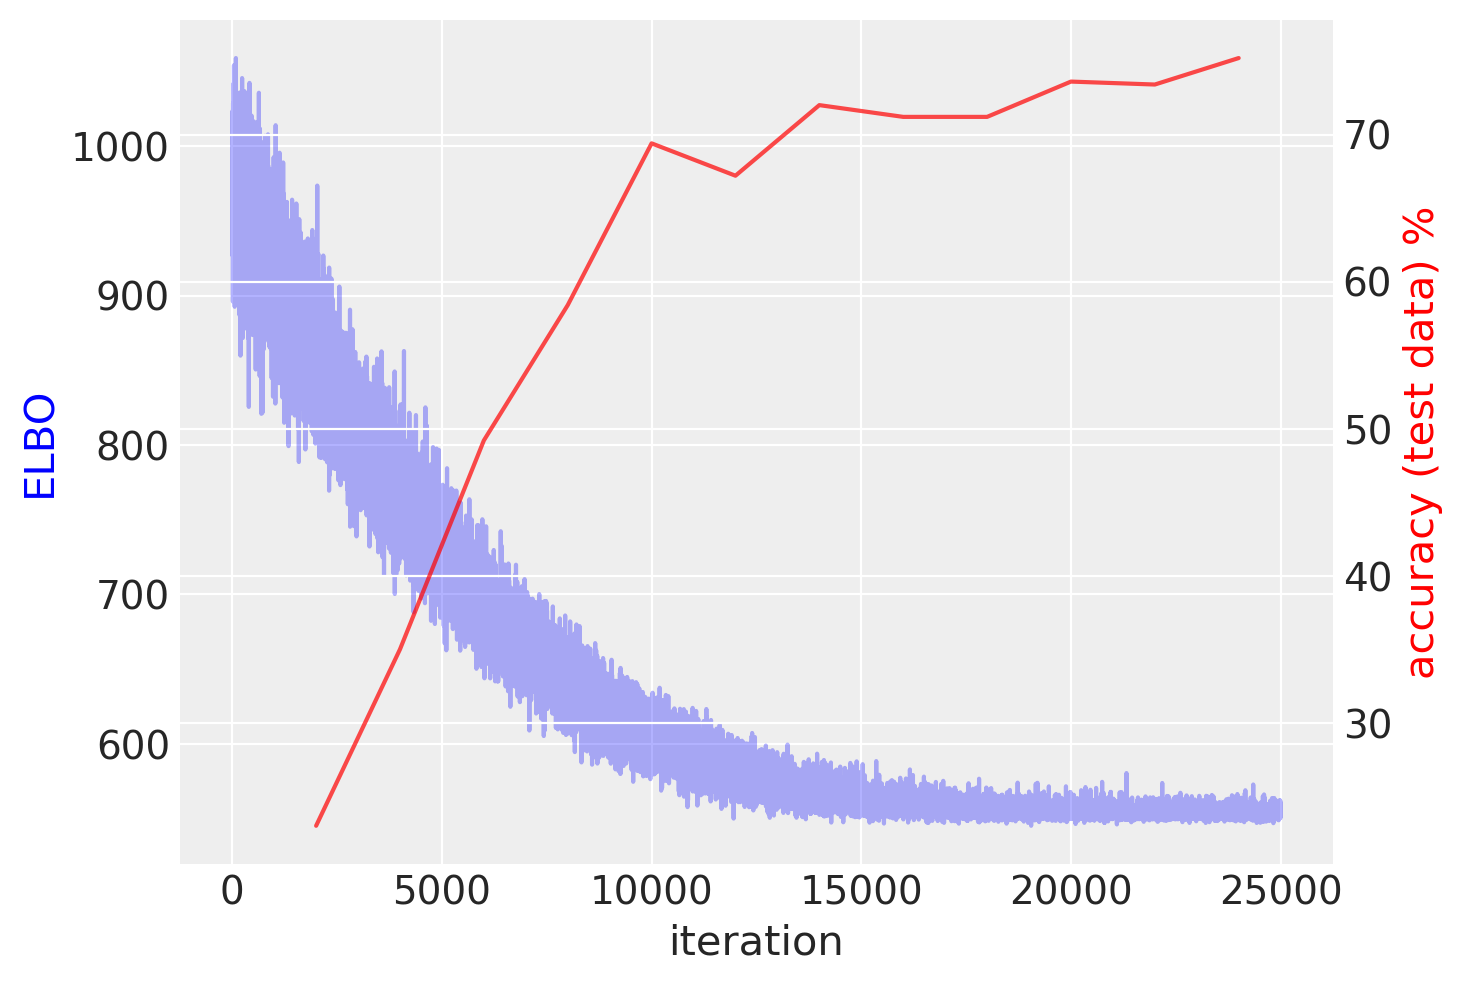

In [23]:
x = ns
y1 = approx.hist
y2 = accs

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(y1, 'blue', alpha=0.3)
ax2.plot(x, y2, 'red', alpha=0.7)

ax1.set_xlabel('iteration')
ax1.set_ylabel('ELBO', color='blue')
ax2.set_ylabel('accuracy (test data) %', color='red')

plt.show()

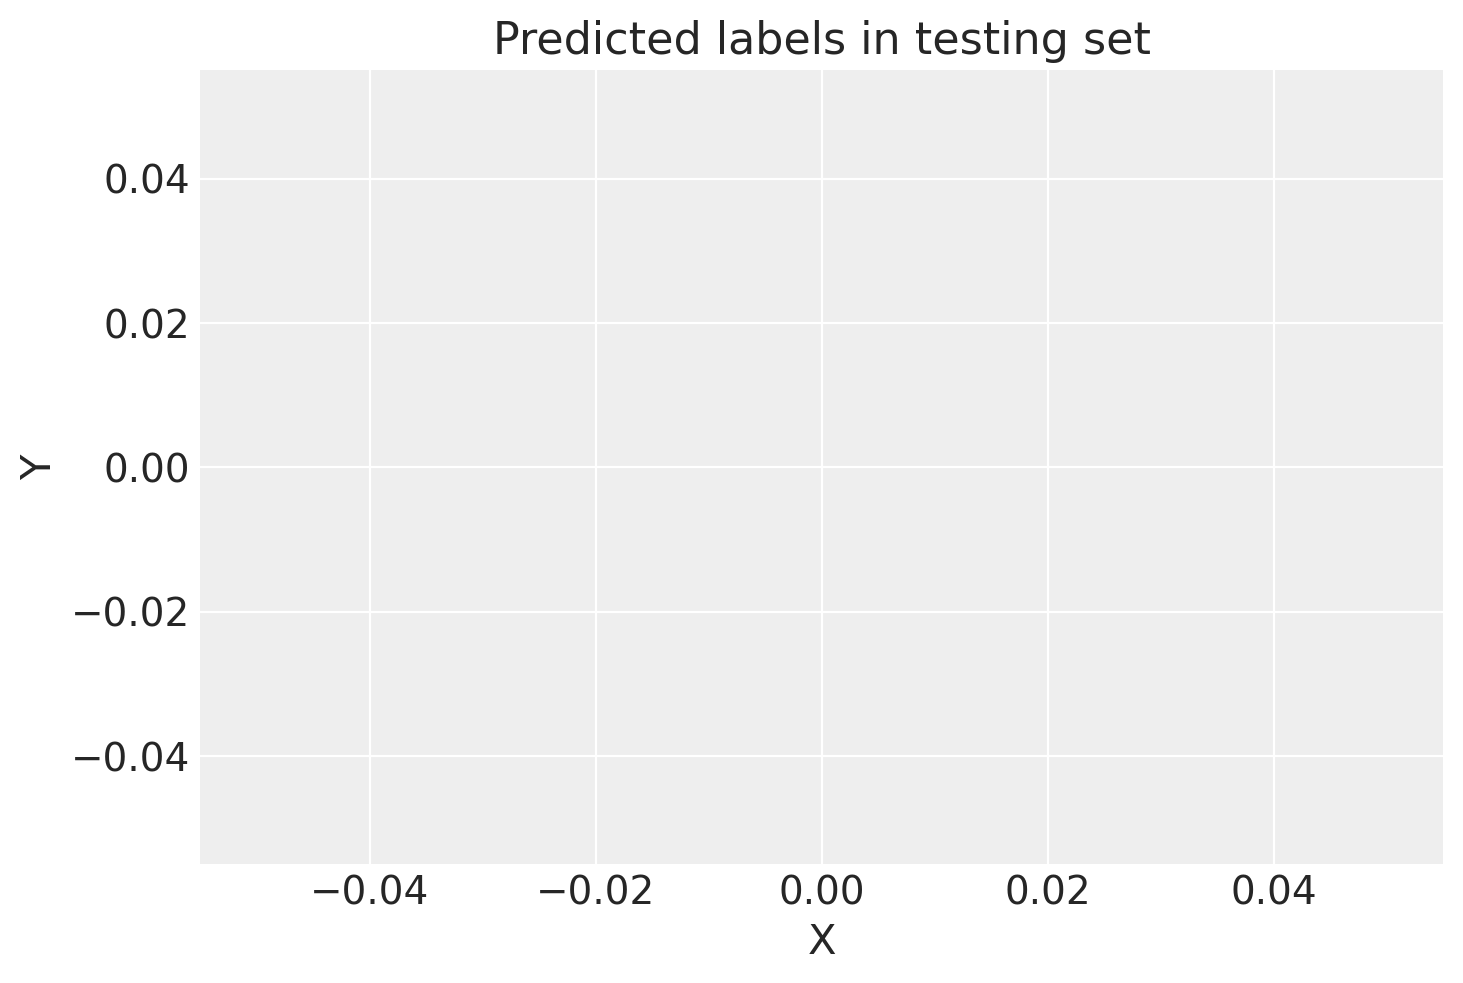

In [24]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
sns.despine()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

In [25]:
f"Accuracy = {(pred == Y_test).mean() * 100}%"

'Accuracy = 76.2%'

#### Verify on `X_test` sample using weights

In [27]:
n = 4

policy = approx.bij.rmap(approx.params[0].eval())['policy']
xt = X_test[n]
detected_id = np.argmax(pm.math.sigmoid(np.dot(policy, xt)).eval())

In [28]:
policy.shape

(6, 6)

In [29]:
Y_test[n]

5.0

In [30]:
detected_id

4

# Ex. 2: Direct mapping + scene + target object

- `dataset03`: \~90% accuracy
- `dataset02`: \~70% accuracy, should be better than in Ex.1 if model and scene vars chosen properly
```
input gestures --> weights_in_g --> \\ weights_gs_out --> ann_output
input scene    --> weights_in_s --> //
```

In [1]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy

from sklearn.model_selection import train_test_split

from srcmodules.Scenes import Scene

%config InlineBackend.figure_format = 'retina'
floatX = aesara.config.floatX
rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

In [2]:
dataset_name = 'dataset02'
n_scene_features = 40

In [3]:
# dataset 
data = np.load(f"{os.path.expanduser('~')}/Documents/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [4]:
def get_X_Y(dataset):
    X = np.zeros([len(dataset),len(dataset[0][2])+n_scene_features])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,sample in enumerate(dataset):
        s = Scene(init='from_dict', import_data=sample[0])
        obs = s.scene_to_observation(type=1)

        X[n] = [*obs, *sample[2]]
        Y[n] = A.index(sample[1][0])
    return X, Y

X,Y = get_X_Y(dataset)

In [5]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [10]:
# TODO:
g2a_in_len = lenG
s2a_in_len = n_scene_features

In [11]:
X_train_g = X_train[:, :lenG]
X_train_s = X_train[:,lenG: ]

In [12]:
lenG

6

In [13]:
def construct_nn(ann_input_g, ann_input_s, ann_output):
    n_hidden = lenA

    # Initialize random weights between each layer
    init_weights_g2a = rng.standard_normal(size=(g2a_in_len, g2a_in_len)).astype(floatX)
    init_weights_s2a = rng.standard_normal(size=(s2a_in_len, s2a_in_len)).astype(floatX)
    init_weights_gs_out = rng.standard_normal(size=(g2a_in_len+s2a_in_len, lenA)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "train_cols_g": np.arange(g2a_in_len),
        "train_cols_g_out": np.arange(g2a_in_len),
        "train_cols_s": np.arange(s2a_in_len),
        "train_cols_s_out": np.arange(s2a_in_len),
        "train_cols_gs": np.arange(g2a_in_len+s2a_in_len),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input_g = pm.Data("ann_input_g", ann_input_g)
        ann_input_s = pm.Data("ann_input_s", ann_input_s)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights from input to hidden layer
        weights_in_g = pm.Normal(
            "weights_in_g", 0, sigma=1, initval=init_weights_g2a, dims=("train_cols_g", "train_cols_g_out")
        )
        weights_in_s = pm.Normal(
            "weights_in_s", 0, sigma=1, initval=init_weights_s2a, dims=("train_cols_s", "train_cols_s_out")
        )
        weights_gs_out = pm.Normal(
            "weights_gs_out", 0, sigma=1, initval=init_weights_gs_out, dims=("train_cols_gs", "hidden_layer_1")
        )
        
        act_1 = pm.math.tanh(pm.math.dot(ann_input_g, weights_in_g))
        act_2 = pm.math.tanh(pm.math.dot(ann_input_s, weights_in_s))
        act_out = pm.math.sigmoid(pm.math.dot(pm.math.concatenate([act_1, act_2], axis=1), weights_gs_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Categorical(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


neural_network = construct_nn(X_train[:, :lenG], X_train[:,lenG: ], Y_train)

In [14]:
graphvizfig = pm.model_to_graphviz(neural_network)
graphvizfig.render(filename=f"/home/petr/Pictures/model_graph_2_{str(np.random.random())[2:]}")

'/home/petr/Pictures/model_graph_2_7738023312799617.pdf'

In [20]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"ann_input_g": X_test[:, :lenG], 'ann_input_s': X_test[:,lenG: ]})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [21]:
ns = []
accs = []
#method = pm.ADVI()
neural_network = construct_nn(X_train_g, X_train_s, Y_train)
with neural_network:
    approx = pm.fit(n=25_000, callbacks=[my_callback])#, method=method)

n: 2000, Accuracy = 21.0%
n: 4000, Accuracy = 23.4%
n: 6000, Accuracy = 22.2%
n: 8000, Accuracy = 24.0%
n: 10000, Accuracy = 23.8%
n: 12000, Accuracy = 24.8%
n: 14000, Accuracy = 21.8%
n: 16000, Accuracy = 22.2%
n: 18000, Accuracy = 21.4%
n: 20000, Accuracy = 22.6%
n: 22000, Accuracy = 23.2%
n: 24000, Accuracy = 23.4%


Finished [100%]: Average Loss = 884.95


In [22]:
trace = approx.sample(draws=500)
with neural_network:
    pm.set_data(new_data={"ann_input_g": X_test[:, :lenG], 'ann_input_s': X_test[:,lenG: ]})
    ppc = pm.sample_posterior_predictive(trace)

In [23]:
pred = ppc_to_pred(ppc)

In [24]:
np.histogram(pred,6)[0]

array([ 70, 107,   0,   0, 183, 140])

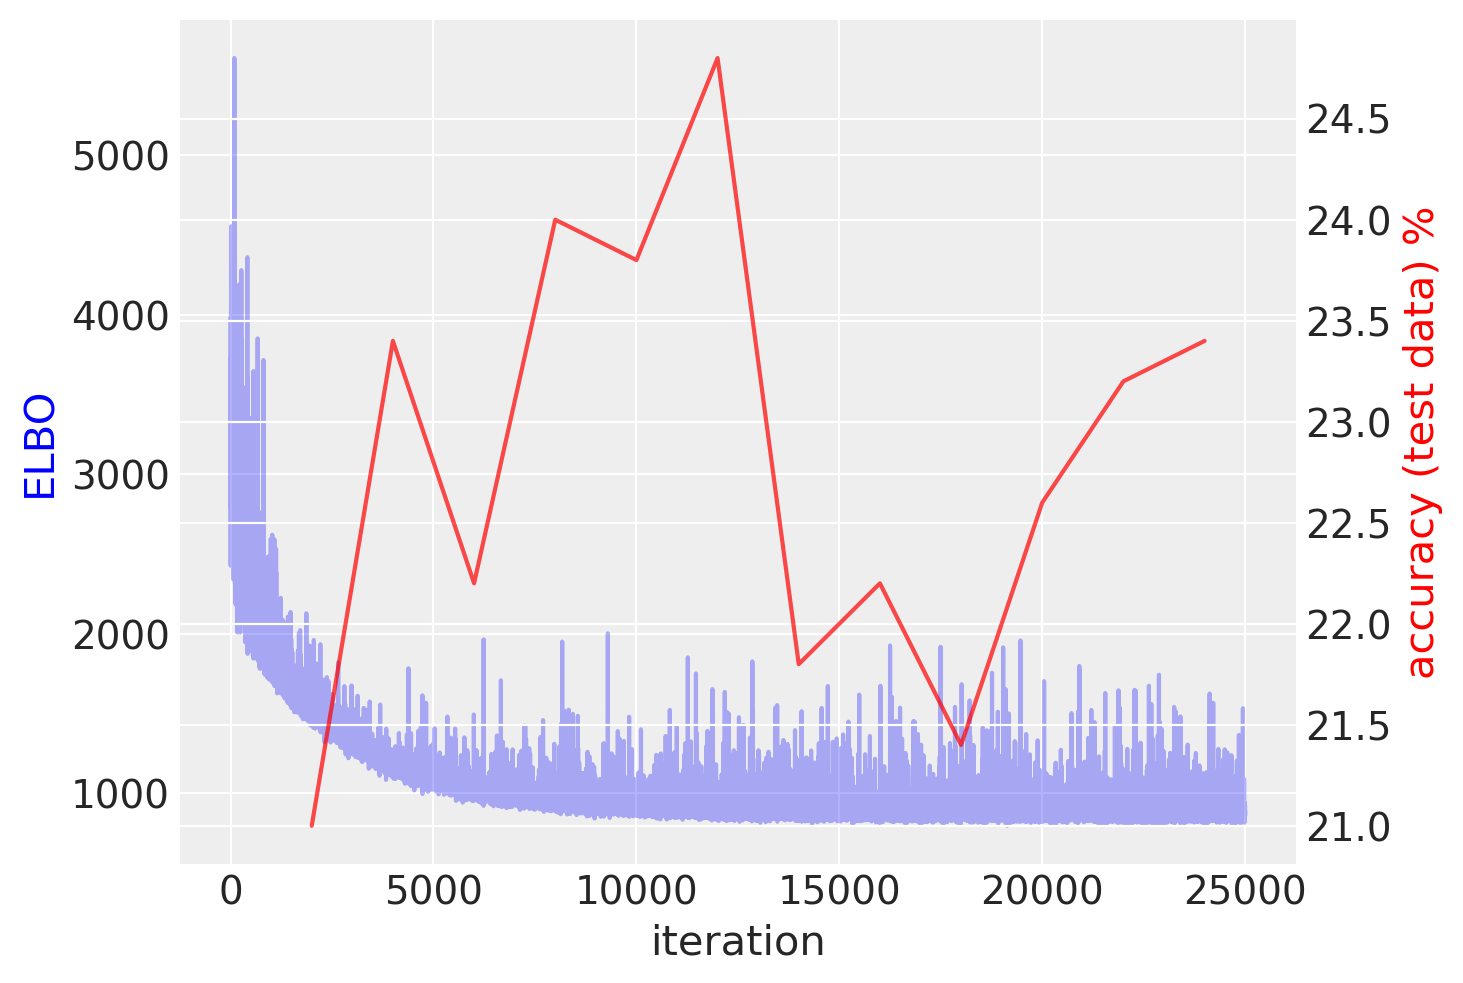

In [25]:
x = ns
y1 = approx.hist
y2 = accs

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(y1, 'blue', alpha=0.3)
ax2.plot(x, y2, 'red', alpha=0.7)

ax1.set_xlabel('iteration')
ax1.set_ylabel('ELBO', color='blue')
ax2.set_ylabel('accuracy (test data) %', color='red')

plt.show()

In [26]:
def plot_predicted labels_in_testing_set(pred, x=0, y=1):
    fig, ax = plt.subplots()
    ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
    ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
    sns.despine()
    ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y")    

SyntaxError: invalid syntax (2686369040.py, line 1)

In [ ]:
f"Accuracy = {(pred == Y_test).mean() * 100}%"

What it can do?
- First examples finds the policy between gestures and action (represented by weights)
- Policy array is by size (n gestures x n actions)
- It doesn't take into account the type of object, user, scene, ...
- The dataset generation on which it is learned can be questioned, if generating the gesture observations properly
- In `dataset02` there is no improvement, when adding scene, scene values do not bring anything valuable the coordinates are absolute values and they do not have connections in classification task 
- The scene values were added, but they don't have influence influence in this setup


In [29]:
s = Scene(init='drawer,drawer,cup,cup,cup', random=True)

In [19]:
len(s.experimental__get_obs())

40

In [27]:
from srcmodules.features import Features

In [32]:
s.object_positions

[array([3, 0, 0]),
 array([2, 2, 0]),
 array([3, 1, 0]),
 array([2, 3, 0]),
 array([1, 2, 0])]

In [34]:
s.r.eef_position

array([3, 0, 3])

In [35]:
Features.eeff__feature(s.object_positions, s.r.eef_position)

array([0., 0., 0., 0., 0.])

# Task 10.9. Generate three datasets

## M. 1: Target object + scene + target object

In [186]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy
from deepdiff import DeepDiff

from sklearn.model_selection import train_test_split

from srcmodules.Scenes import Scene
from srcmodules.features import Features

%config InlineBackend.figure_format = 'retina'
floatX = aesara.config.floatX
rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

In [267]:
dataset_name = 'dataset2_1_10000d'

In [268]:
# dataset 
data = np.load(f"{os.path.expanduser('~')}/Documents/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [269]:
def get_X_Y(dataset):
    X = np.zeros([len(dataset),len(dataset[0][2])])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,sample in enumerate(dataset):
        s = Scene(init='from_dict', import_data=sample[0])
        obs = [] #s.scene_to_observation(type=1)

        X[n] = [*obs, *sample[2]]
        Y[n] = A.index(sample[1][0])
    return X, Y

X,Y = get_X_Y(dataset)

In [270]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [271]:
n_obs_in = lenG

In [272]:
def construct_nn(ann_input, ann_output):
    n_hidden = lenA
    
    # Initialize the weights/policy values
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights/policy symbolic variable
        weights_in_1 = pm.Normal(
            "policy", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )
        act_out = pm.math.sigmoid(pm.math.dot(ann_input, weights_in_1))
        out = pm.Categorical(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],
        )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

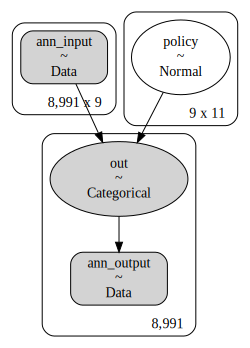

In [273]:
pm.model_to_graphviz(neural_network)

In [274]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"ann_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [275]:
ns = []
accs = []
#method = pm.ADVI()
neural_network = construct_nn(X_train, Y_train)
with neural_network:
    approx = pm.fit(n=25_000, callbacks=[my_callback])#, method=method)

n: 2000, Accuracy = 14.81%
n: 4000, Accuracy = 23.02%
n: 6000, Accuracy = 29.93%
n: 8000, Accuracy = 35.94%
n: 10000, Accuracy = 45.65%
n: 12000, Accuracy = 53.25%
n: 14000, Accuracy = 59.36%
n: 16000, Accuracy = 61.26%
n: 18000, Accuracy = 62.96%
n: 20000, Accuracy = 66.17%
n: 22000, Accuracy = 67.67%
n: 24000, Accuracy = 66.87%


Finished [100%]: Average Loss = 9,289.3


Results of Model 1 (1L, 11 Hidden layer size fixed):
- Dataset 1:
    - M(100 s) = 18
    - M(200 s) = 25
    - M(400 s) = 40
    - M(1000 s) = 62
    - M(2500 s) = 67
    - M(5000 samples) = 70
    - M(9000 samples) = 67    
- Dataset 2:
    - M(5000 samples) = 68
- Dataset 3:
    - M(5000 samples) = 68
    - M(1000 s ) = 63
    - M(100 s) = ~18

## M. 2: Model 2: Target object + scene + target object


In [290]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy
from deepdiff import DeepDiff

from sklearn.model_selection import train_test_split

from srcmodules.Scenes import Scene
from srcmodules.features import Features

%config InlineBackend.figure_format = 'retina'
floatX = aesara.config.floatX
rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

In [310]:
dataset_name = 'dataset2_3_10000d'
n_scene_features = 52

In [312]:
# dataset 
data = np.load(f"{os.path.expanduser('~')}/Documents/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [313]:
def get_X_Y(dataset):
    X = np.zeros([len(dataset),len(dataset[0][2])+n_scene_features])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,sample in enumerate(dataset):
        s = Scene(init='from_dict', import_data=sample[0])
        obs = s.scene_to_observation(type=1)
        
        ll = len(sample[2]) + len(obs)
        X[n,0:ll] = [*sample[2], *obs]
        Y[n] = A.index(sample[1][0])
    return X, Y

X,Y = get_X_Y(dataset)

In [314]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [315]:
# TODO:
n_obs_in = lenG + n_scene_features

In [316]:
def construct_nn(ann_input, ann_output):
    n_hidden = 25

    # Initialize random weights between each layer
    init_weights_1 = rng.standard_normal(size=(n_obs_in, n_hidden)).astype(floatX)
    init_weights_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_weights_3 = rng.standard_normal(size=(n_hidden, lenA)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "hidden_layer_3": np.arange(n_hidden),
        "train_cols": np.arange(n_obs_in),
        "out_dim": np.arange(lenA),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", ann_input)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights from input to hidden layer
        weights_1 = pm.Normal(
            "weights_1", 0, sigma=1, initval=init_weights_1, dims=("train_cols", "hidden_layer_1")
        )
        weights_2 = pm.Normal(
            "weights_2", 0, sigma=1, initval=init_weights_2, dims=("hidden_layer_1", "hidden_layer_2")
        )
        weights_3 = pm.Normal(
            "weights_3", 0, sigma=1, initval=init_weights_3, dims=("hidden_layer_2", "out_dim")
        )
        
        act_1   = pm.math.tanh(pm.math.dot(ann_input, weights_1))
        act_2   = pm.math.tanh(pm.math.dot(weights_1, weights_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_1, weights_3))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Categorical(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

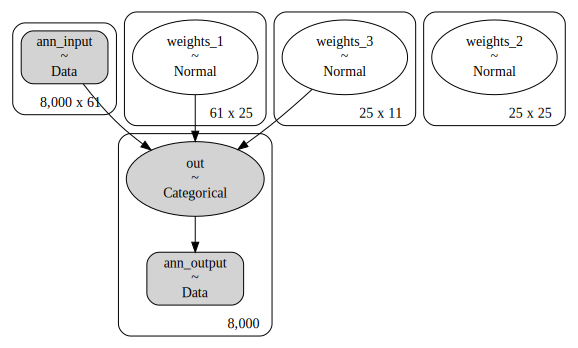

In [317]:
pm.model_to_graphviz(neural_network)

In [318]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"ann_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [319]:
ns = []
accs = []
#method = pm.ADVI()
neural_network = construct_nn(X_train, Y_train)
with neural_network:
    approx = pm.fit(n=25_000, callbacks=[my_callback])#, method=method)

n: 2000, Accuracy = 16.15%
n: 4000, Accuracy = 14.55%


Interrupted at 4,127 [16%]: Average Loss = 21,045


# Compare three models as a histogram of accuracies

In [320]:
model1_accs = [70,68,68]
model2_accs = [18,17,18]
model3_accs = [0,0,0]

/tmp/ipykernel_13695/1647915420.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


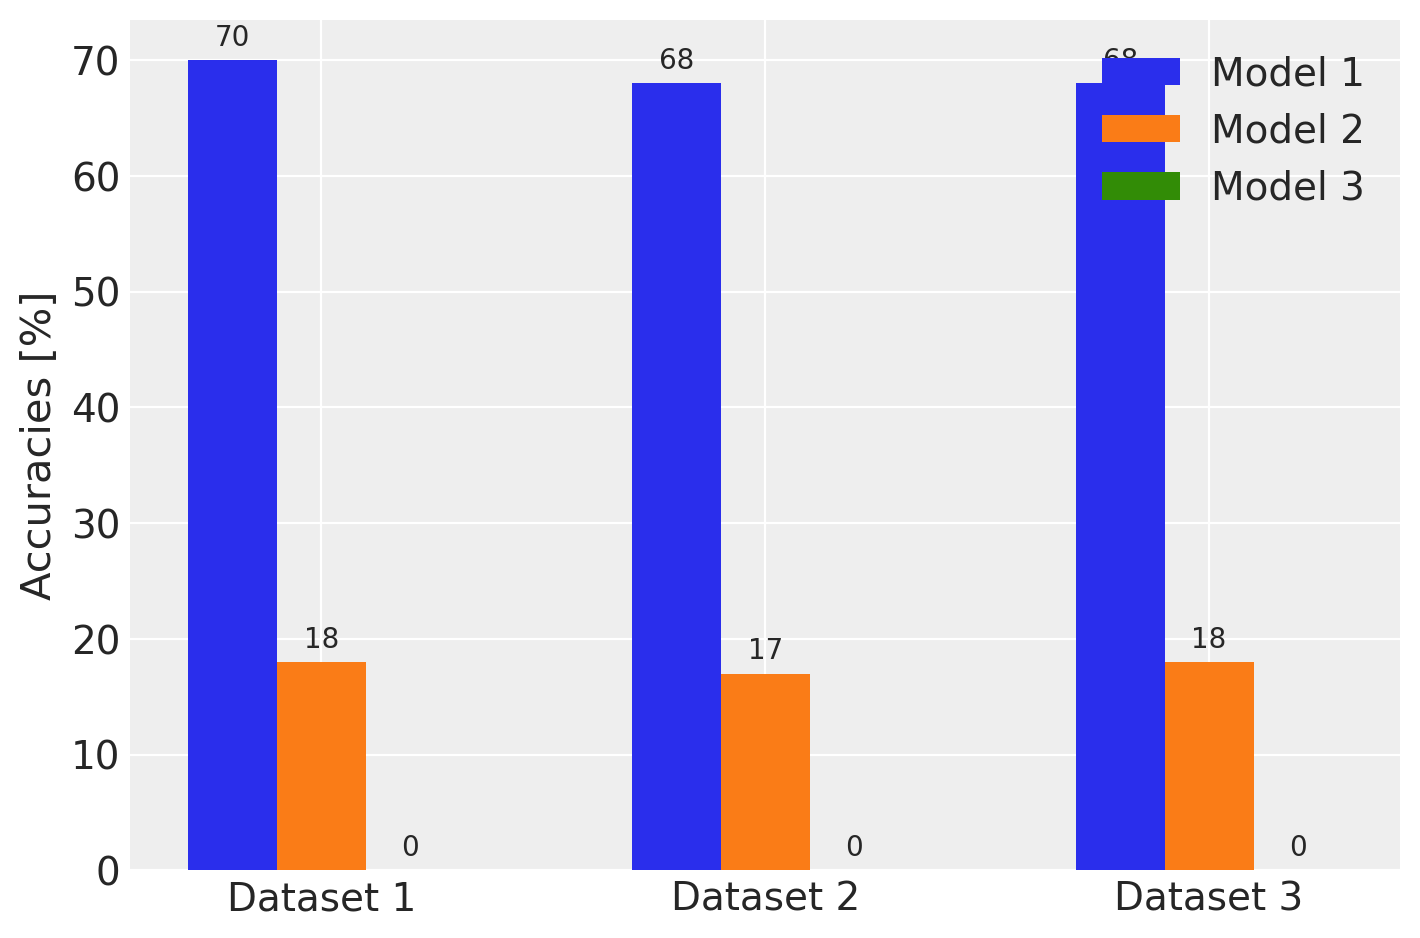

In [321]:
labels = ['Dataset 1', 'Dataset 2', 'Dataset 3']

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, model1_accs, width, label='Model 1')
rects2 = ax.bar(x        , model2_accs, width, label='Model 2')
rects3 = ax.bar(x + width, model3_accs, width, label='Model 3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracies [%]')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()